# Basketball challenge

In [15]:
from PIL import Image
import pickle
import torch
import torchvision
import io
import os
from Dataset import Basketball
from Dataprocess import Preprocess
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image transformation

In [16]:
img_transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,48)),
    torchvision.transforms.CenterCrop((48,48)),
    torchvision.transforms.ToTensor()
])


# Preprocessing Dataset

In [17]:
dataprocess = Preprocess().background_subtractor

# Loading Dataset

In [18]:
path = "data"
training_data = Basketball(path, split='training', num_frame = 100, img_transform = img_transformation, dataprocess=dataprocess)

In [37]:
view1 = training_data.__getitem__(0)[1]

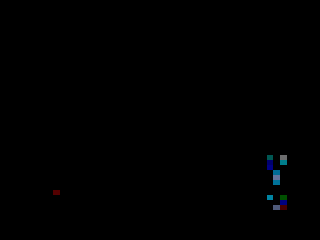

0

In [54]:
from IPython import display
import torchvision.transforms.functional as F

for index in range(10):
    view1 = training_data.__getitem__(index)[0]
    for idx, img in enumerate(view1):
        img1 = F.to_pil_image(img)
        display.display(img1.resize((320,240)), Image.NEAREST)
        display.clear_output(wait=True)

In [ ]:
import torchvision.transforms.functional as F
save_dir = 'cache/training'
for i in range(training_data.__len__()):
    sample = training_data.__getitem__(i)
    view1_raw = sample[0]
    view2_raw = sample[1]
    label = sample[2]
    view1 = Preprocess().background_subtractor(view1_raw)
    view2 = Preprocess().background_subtractor(view2_raw)
    
    for idx, _ in enumerate(view1):
        img1 = F.to_pil_image(view1[idx])
        img2 = F.to_pil_image(view2[idx])
        savepath = os.path.join(save_dir, label, str(i))
        
        savept1 = os.path.join(savepath, 'view1')
        if not os.path.isdir(savept1):
            os.makedirs(savept1)
        torch.save(img1, os.path.join(savept1, str(idx)))
        
        savept2 = os.path.join(savepath, 'view2')
        if not os.path.isdir(savept2):
            os.makedirs(savept2)
        torch.save(img2, os.path.join(savept2, str(idx)))
        
    print('saved ', i)

In [ ]:
openpath = os.path.join(save_dir, 'hit', '0', 'view1', '0')
view1_loaded = torch.load(openpath)
img = torchvision.transforms.ToTensor()
img1 = img(view1_loaded)
img1.shape

In [ ]:
path = "Processed"
training_data = Basketball(path, split='training', num_frame = 100, img_transform = img_transformation)


In [ ]:
view1.shape

In [ ]:
view1.view(len(view1), -1).shape